In [14]:
import numpy as np
import pandas as pd
import scipy as sp
import plotly.express as px
import networkx as nx
import degroot as dg
from tqdm import tqdm
import plotly.graph_objects as go
from joblib import Parallel, delayed

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Parameters
dims = 12
erdos_reni_p = 0.3
init_belief = np.random.uniform(0, 1, size=dims)
niter_degroot = 2

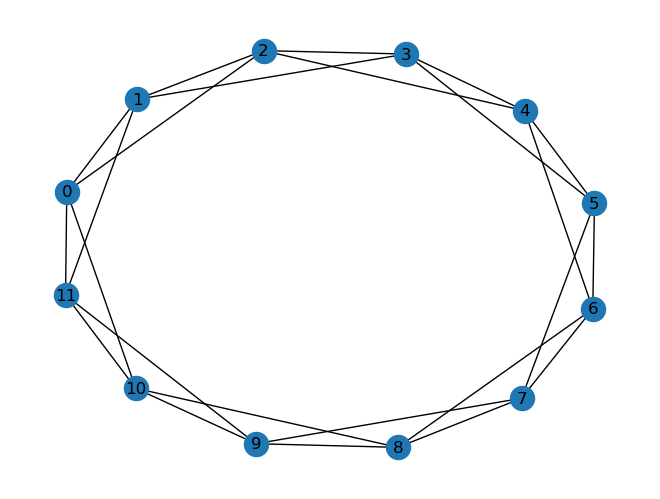

In [23]:
n = nx.connected_watts_strogatz_graph(n=dims, k=4, p=3 / (dims * 4))
nx.draw(n, with_labels=True)
m_base = nx.adjacency_matrix(n).todense()

In [24]:
rewiring_sample = [nx.adjacency_matrix(nx.connected_watts_strogatz_graph(n=dims, k=4, p=3 / (dims * 4))).todense() for _ in range(100)]

In [25]:
correct_belief = 0.9

In [26]:
dg.degroot_err(m_base, init_belief, correct_belief, niter_degroot)

(0.3653184902076699,
 array([0.59551314, 0.49282078, 0.44777999, 0.453906  , 0.41016212,
        0.37820424, 0.45519128, 0.5957252 , 0.62105866, 0.59679843,
        0.67838386, 0.69063441]))

In [27]:
peaks = dg.find_local_peaks(sample=rewiring_sample, initial_belief=init_belief, correct_belief=correct_belief, niter_degroot=niter_degroot, vision=1)

100%|██████████| 100/100 [00:02<00:00, 44.69it/s]


In [29]:
unique_peaks = np.unique([p['m'].flatten() for p in peaks], axis=0)
unique_peaks_labels = {p.tobytes(): i for i, p in enumerate(unique_peaks)}
print(f"Unique peaks: {len(unique_peaks)}")

res = []
for p in peaks:
    peak = p['m'].flatten().astype(int).tobytes()
    peak_label = unique_peaks_labels[peak]
    error = p['error']
    estimate = p['estimate']
    res.append({'peak_label': peak_label, 'error': error, 'estimate': estimate})

res = pd.DataFrame(res)
res = res.groupby('peak_label').agg({'error': 'mean', 'estimate': 'mean', 'peak_label': 'count'})
res.sort_values('error', inplace=True)
res

Unique peaks: 75


,error,estimate,peak_label
peak_label,,,
0,0.021876,0.878124,1
3,0.028376,0.871624,1
42,0.030621,0.869379,1
22,0.030621,0.869379,1
65,0.030621,0.869379,2
...,...,...,...
57,0.051471,0.848529,1
9,0.052866,0.847134,1
73,0.053090,0.846910,1
